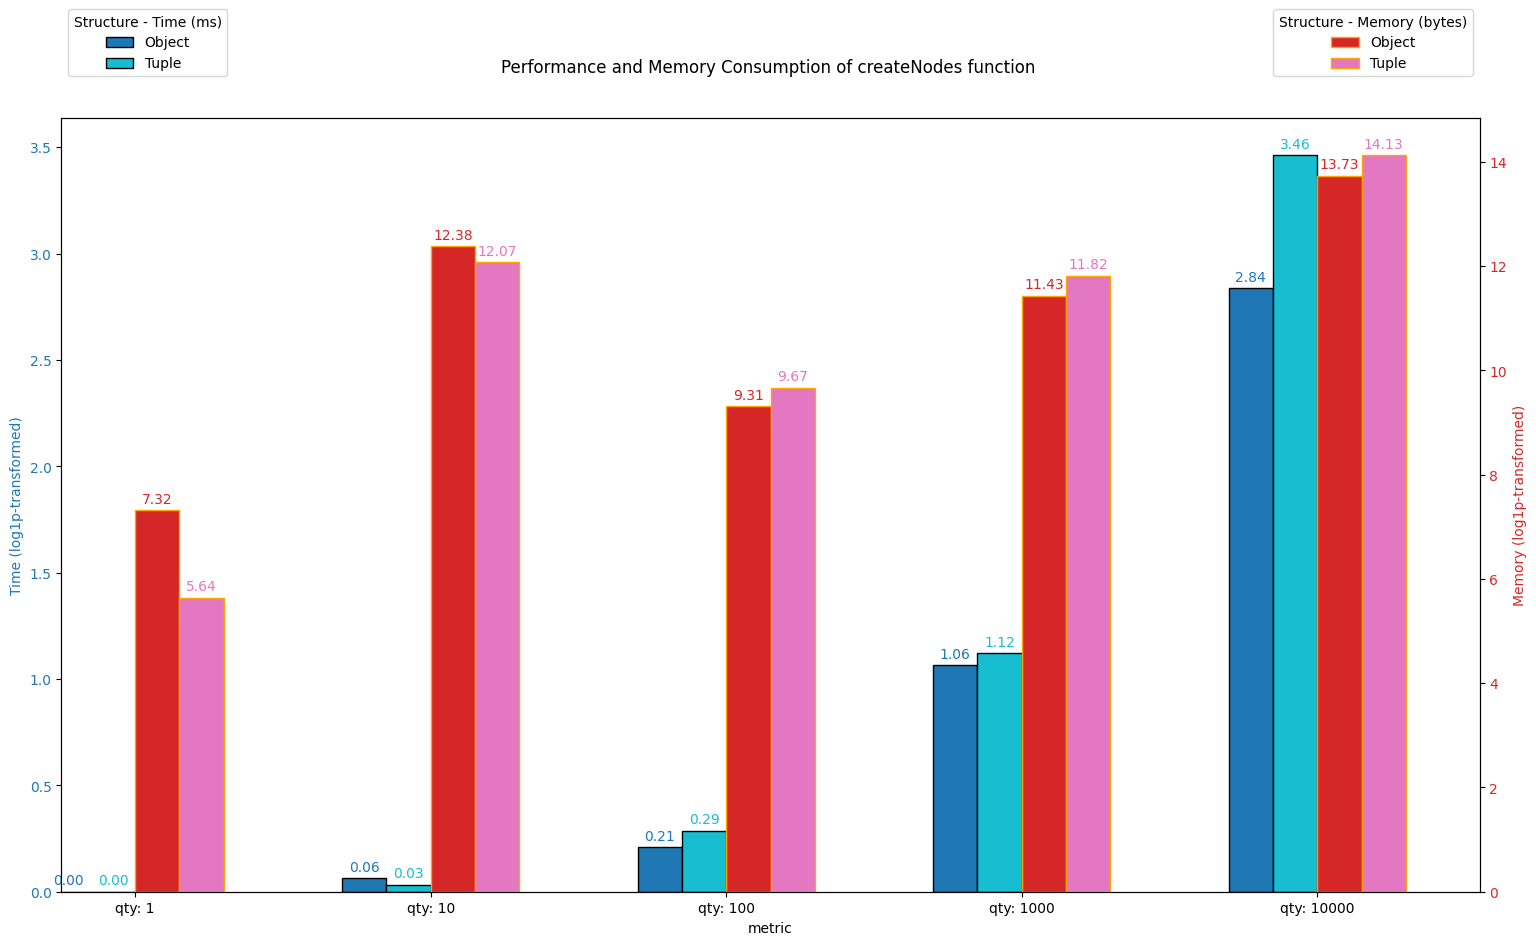

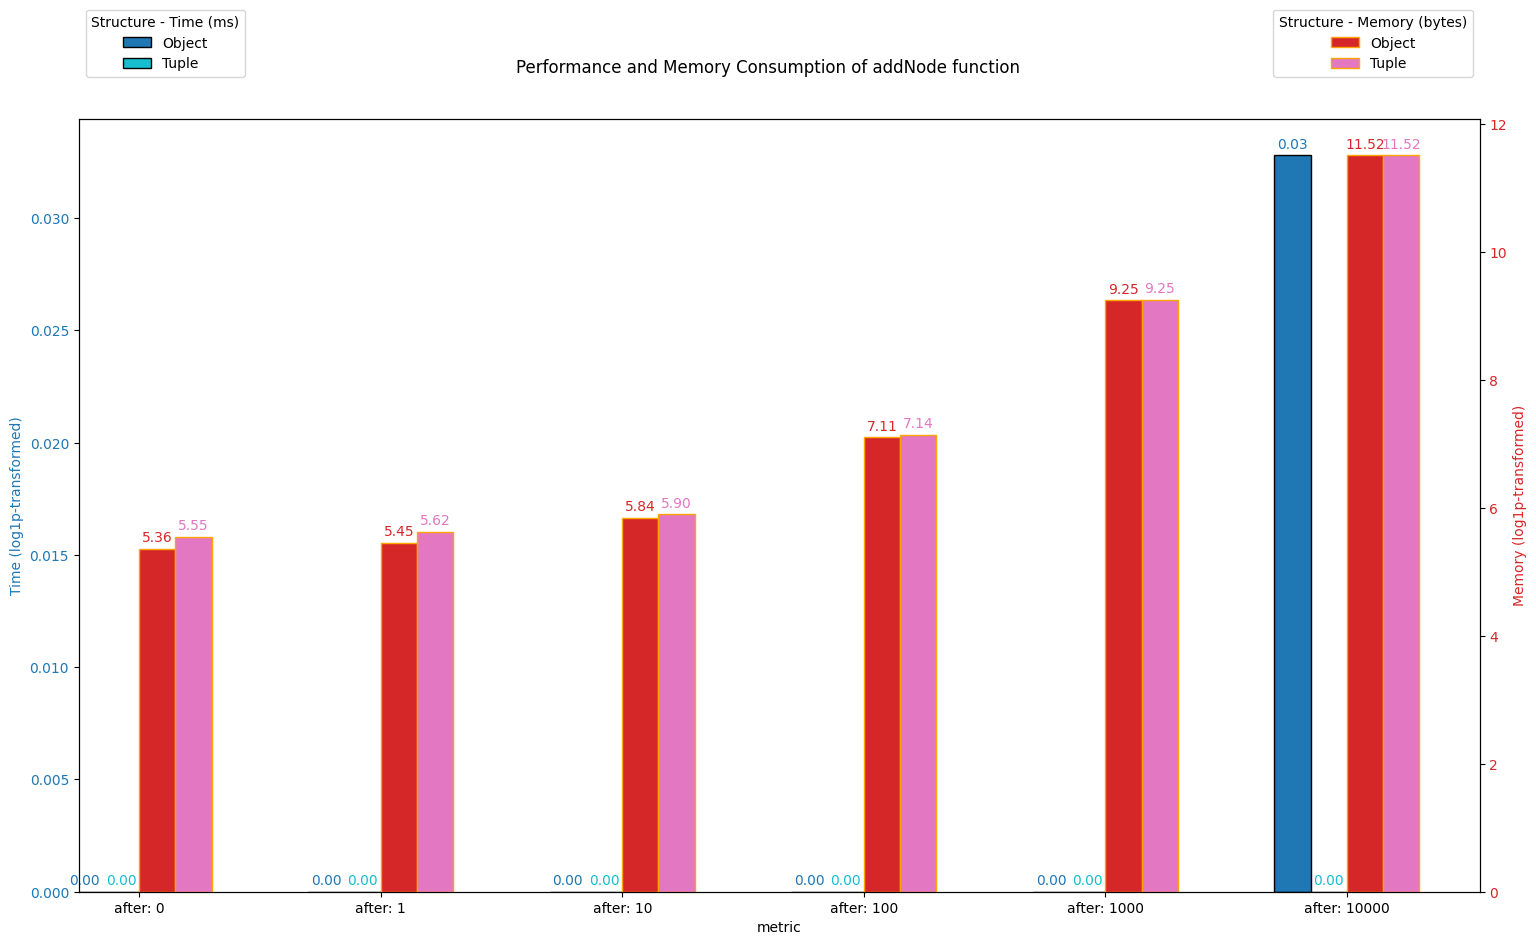

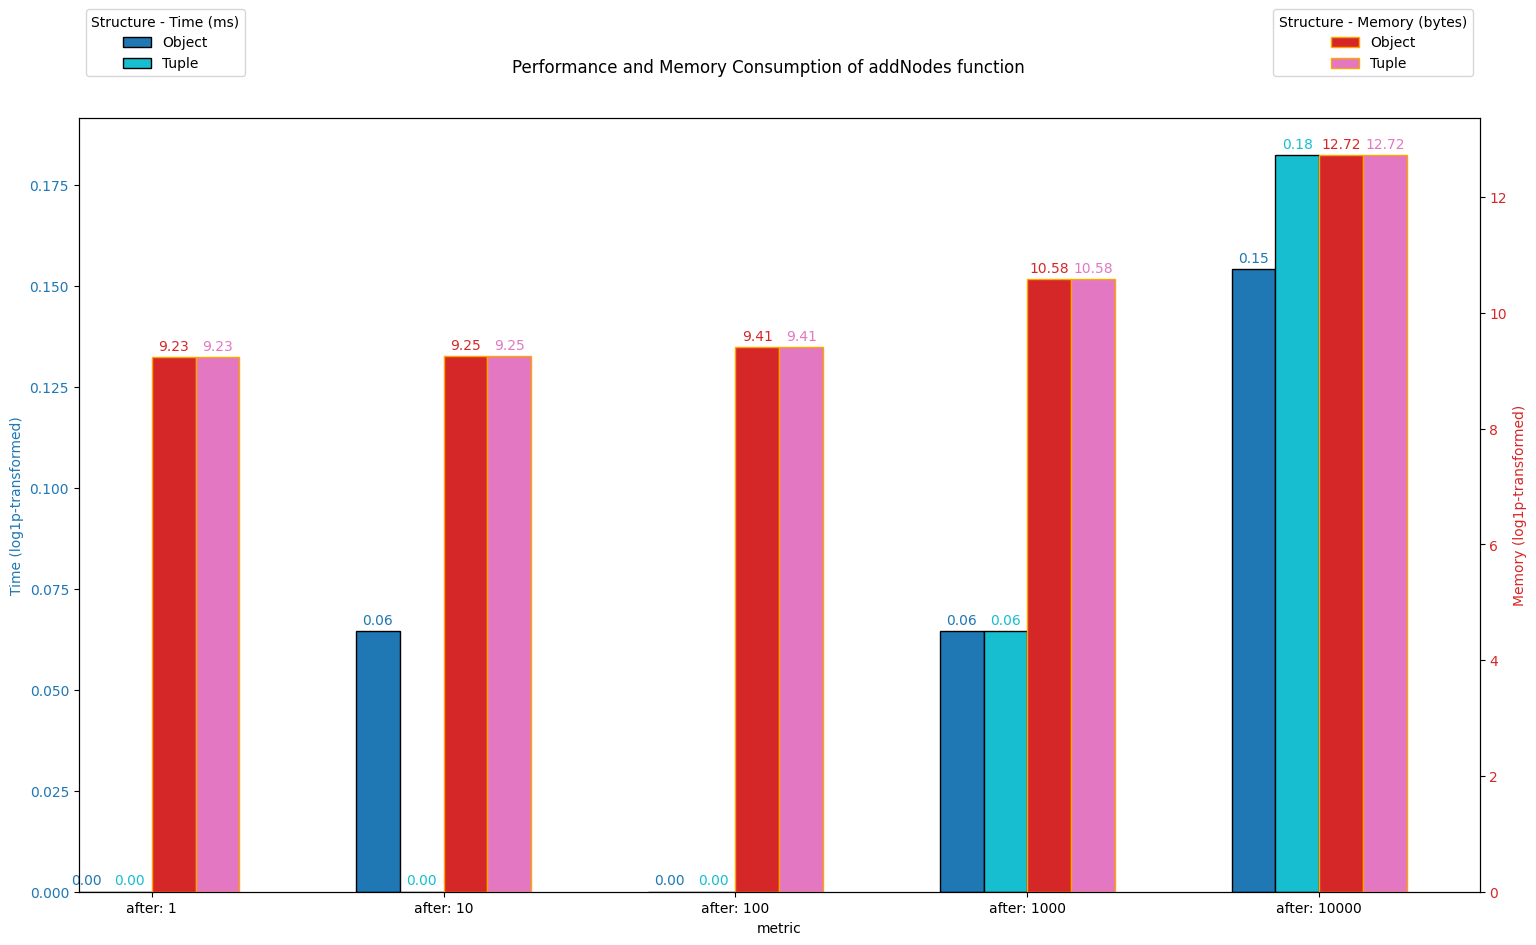

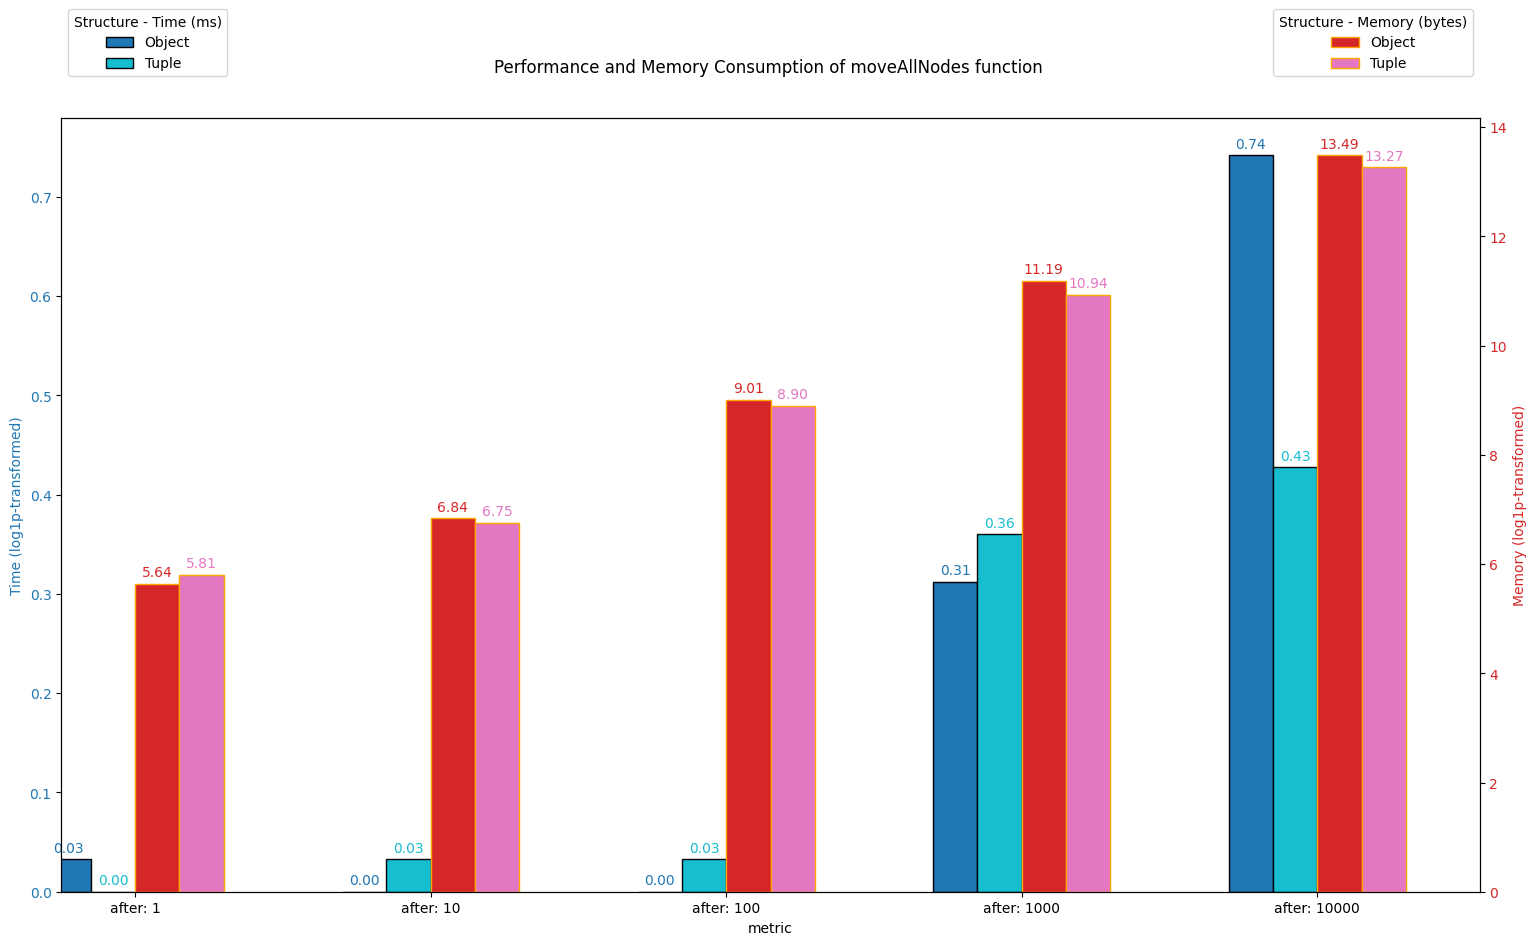

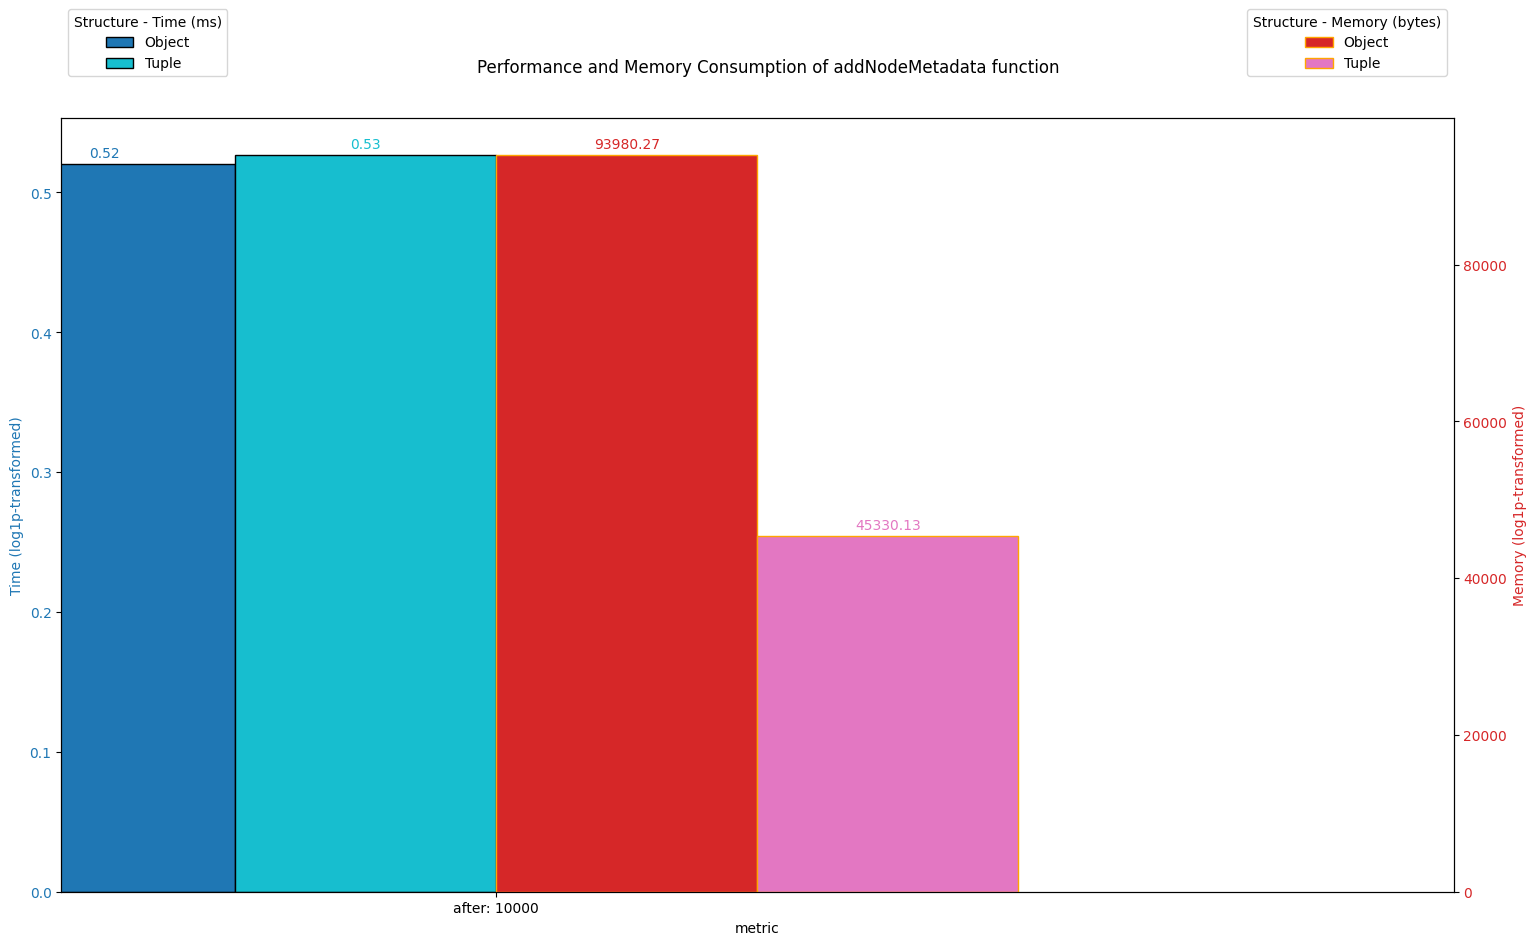

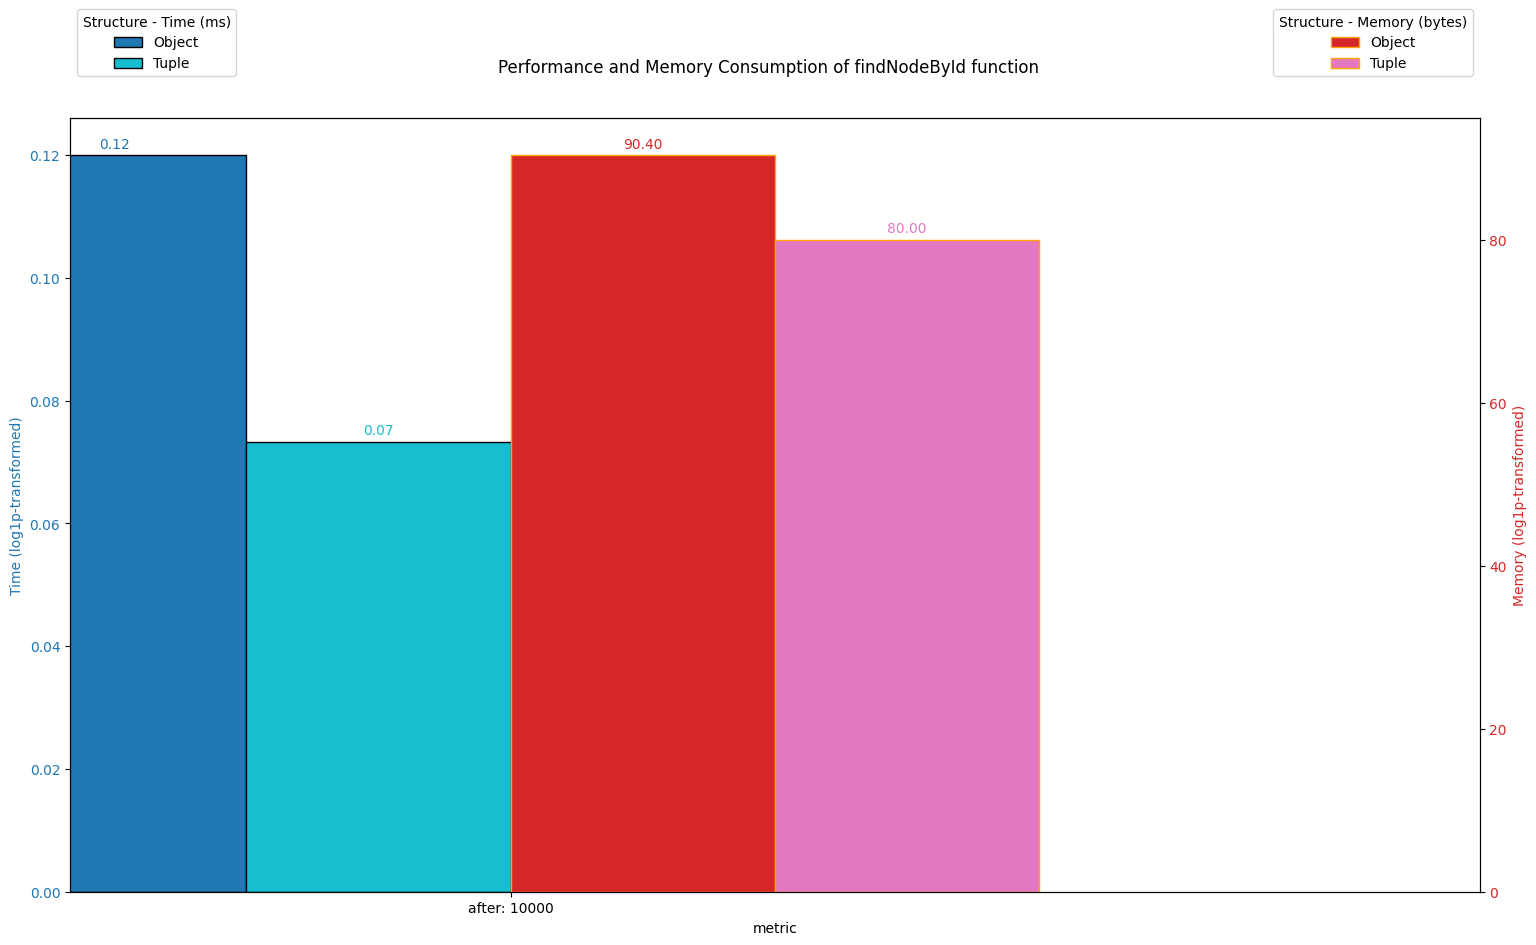

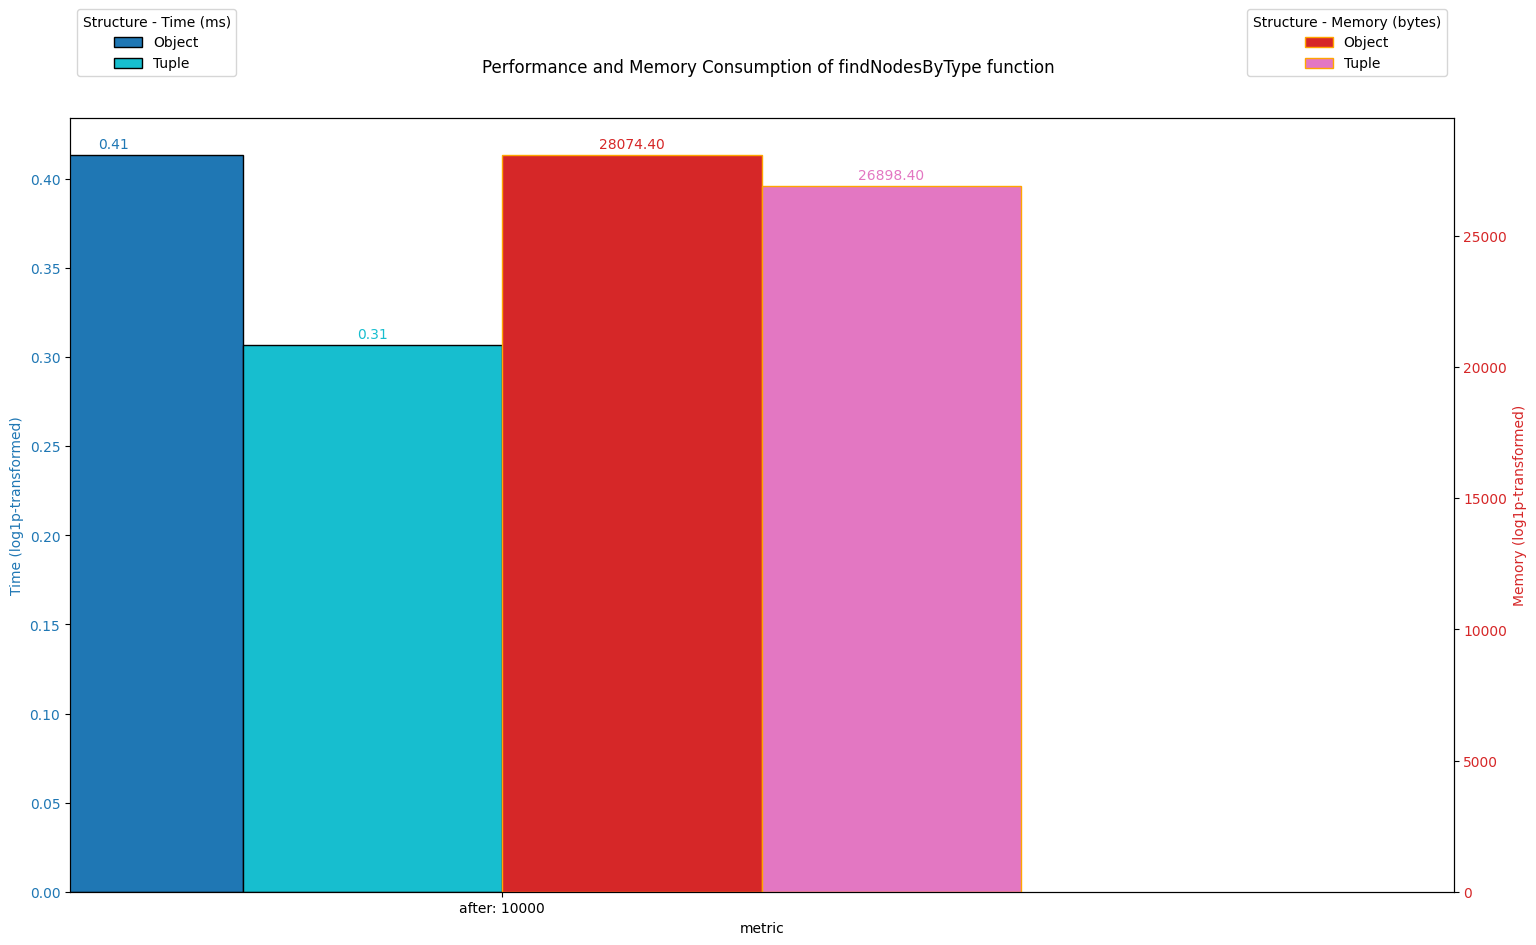

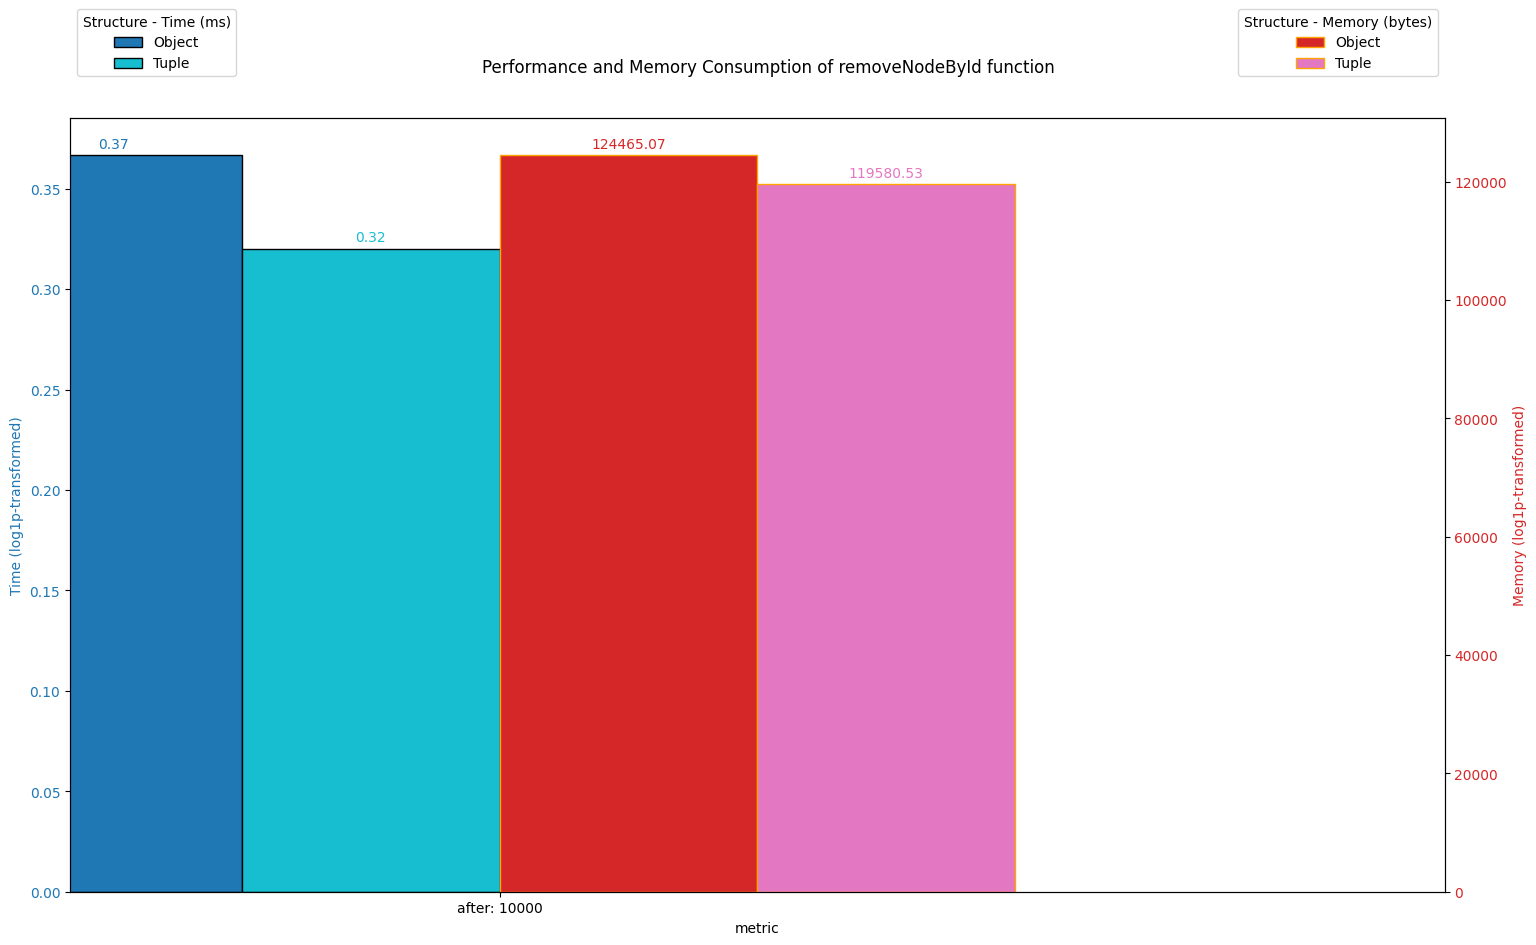

In [1]:
%matplotlib inline
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Function to process each data file
def process_data(file_path):
    with open(file_path) as f:
        data = json.load(f)

    performance_rows = []
    memory_rows = []

    for entry in data:
        measurement = entry['measurement']
        
        if 'performance' in measurement:
            structure = measurement['performance']['structure']
            action = measurement['performance']['action']
            qty_or_after = measurement['performance'].get('qty', measurement['performance'].get('after'))
            metric_type = 'qty' if 'qty' in measurement['performance'] else 'after'
            time = measurement['performance']['time']
            performance_rows.append([structure, action, metric_type, qty_or_after, time])
        
        if 'memory' in measurement:
            structure = measurement['memory']['structure']
            action = measurement['memory']['action']
            qty_or_after = measurement['memory'].get('qty', measurement['memory'].get('after'))
            metric_type = 'qty' if 'qty' in measurement['memory'] else 'after'
            size = measurement['memory']['size']
            memory_rows.append([structure, action, metric_type, qty_or_after, size])

    performance_df = pd.DataFrame(performance_rows, columns=['structure', 'action', 'metric_type', 'metric_value', 'time'])
    memory_df = pd.DataFrame(memory_rows, columns=['structure', 'action', 'metric_type', 'metric_value', 'size'])
    
    return performance_df, memory_df

# Process all three files
performance_dfs = []
memory_dfs = []

for i in range(1, 4):
    perf_df, mem_df = process_data(f"../output/benchmark.report.{i}.json")  # Change the path as per your file locations
    performance_dfs.append(perf_df)
    memory_dfs.append(mem_df)

# Concatenate dataframes
all_performance_df = pd.concat(performance_dfs)
all_memory_df = pd.concat(memory_dfs)

# Group by necessary columns and calculate the mean
performance_df = all_performance_df.groupby(['structure', 'action', 'metric_type', 'metric_value'], as_index=False).mean()
memory_df = all_memory_df.groupby(['structure', 'action', 'metric_type', 'metric_value'], as_index=False).mean()

# Log1p Transformation with handling zero/negative values


# Log1p Transformation with handling zero/negative values
def log1p_transform(df, value_column, exclude_actions):
    epsilon = 1e-10  # Small constant to avoid log(0)
    df[value_column] = df.apply(lambda row: np.log1p(row[value_column] + epsilon) if row['action'] not in exclude_actions and row[value_column] > 0 else row[value_column], axis=1)
    return df

# Actions to be excluded from log1p transformation
exclude_actions = [
    'addNodeMetadata', 
    'findNodeById', 
    'findNodesByType', 
    'removeNodeById'
]

# Apply log1p transformation to time and size columns
performance_df = log1p_transform(performance_df, 'time', exclude_actions)
memory_df = log1p_transform(memory_df, 'size', exclude_actions)

# Merging performance and memory data
merged_df = pd.merge(performance_df, memory_df, on=['structure', 'action', 'metric_type', 'metric_value'], suffixes=('_time', '_memory'))

# Combine metric type and value for unique x-axis labels
merged_df['metric'] = merged_df['metric_type'] + ': ' + merged_df['metric_value'].astype(str)

# Plotting the combined graphs with log1p scale and annotations
def plot_combined_graph(df, action):
    subset = df[df['action'] == action]
    pivot_time_df = subset.pivot(index='metric', columns='structure', values='time')
    pivot_memory_df = subset.pivot(index='metric', columns='structure', values='size')

    fig, ax1 = plt.subplots(figsize=(16, 9))  # Increase figure size

    bar_width = 0.3  # Adjust the bar width
    rotation_angle = 0  # Adjust the rotation angle for x-tick labels

    # Plot time bars
    ax1.set_xlabel('Metric (qty/after)')
    ax1.set_ylabel('Time (log1p-transformed)', color='tab:blue')
    bars1 = pivot_time_df.plot(
        kind='bar', ax=ax1, position=1, width=bar_width, 
        color=['tab:blue', 'tab:cyan'], legend=False, edgecolor='black'
    )
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.tick_params(axis='x', labelrotation=rotation_angle)  # Rotate x-tick labels for better readability

    # Plot memory bars
    ax2 = ax1.twinx()
    ax2.set_ylabel('Memory (log1p-transformed)', color='tab:red')
    bars2 = pivot_memory_df.plot(
        kind='bar', ax=ax2, position=0, width=bar_width, 
        color=['tab:red', 'tab:pink'], legend=False, edgecolor='orange'
    )
    ax2.tick_params(axis='y', labelcolor='tab:red')
    ax2.tick_params(axis='x', labelrotation=rotation_angle)  # Rotate x-tick labels for better readability

    # Annotate bars with their values
    def annotate_bars(ax, bars, color='black'):
        for bar in bars.patches:
            height = bar.get_height()
            if not np.isnan(height):
                ax.annotate(f'{height:.2f}', 
                            xy=(bar.get_x() + bar.get_width() / 2, height), 
                            xytext=(0, 3),  # 3 points vertical offset
                            textcoords="offset points", 
                            ha='center', va='bottom', color=bar.get_facecolor()
                            )

    annotate_bars(ax1, bars1)
    annotate_bars(ax2, bars2)

    fig.tight_layout(pad=3)
    fig.suptitle(f'Performance and Memory Consumption of {action} function', y=1.02)
    ax1.legend(loc='upper left', bbox_to_anchor=(0, 1.15), title='Structure - Time (ms)')
    ax2.legend(loc='upper right', bbox_to_anchor=(1, 1.15), title='Structure - Memory (bytes)')

    plt.show()

    # Save the plot as an image
    fig.savefig(f'../output/plots/{action}_combined.png', bbox_inches='tight')  # Change the path as per your file locations

keys = [
    'createNodes', 
    'addNode', 
    'addNodes', 
    'moveAllNodes', 
    'addNodeMetadata', 
    'findNodeById', 
    'findNodesByType', 
    'removeNodeById'
]

# Plot combined graphs for each action
for action in sorted(merged_df['action'].unique(), key=lambda x: keys.index(x)):
    plot_combined_graph(merged_df, action)
